<a href="https://colab.research.google.com/github/silasabs/CoherentOptics/blob/main/Jupyter/Carrier%20Recovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

# Recuperação de Portadora

Este notebook contém algumas implementações dos principais algoritmos que realizam a recuperação de portadora em receptores ópticos digitais coerentes, com a finalidade de compensar o deslocamento de frequência da portadora e o ruído de fase.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

from optic.dsp.core import pulseShape, firFilter, decimate, symbolSync, pnorm, signal_power
from optic.models.devices import pdmCoherentReceiver, basicLaserModel
from optic.models.channels import linearFiberChannel, awgn
from optic.models.tx import simpleWDMTx
from optic.utils import parameters
from optic.comm.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, calcEVM
from optic.plot import pconst

import scipy.constants as const

## 6.1 Frequency Recovery

Existem dois efeitos de fase principais que afetam os sistemas ópticos coerentes digitais. O primeiro é um deslocamento de frequência da portadora, o segundo é o ruído de fase.

Assumindo uma detecção coerente intradina, os lasers transmissores e osciladores locais não operam exatamente na mesma frequência, mas exibem um deslocamento que pode atingir a ordem de alguns gigahertz. Após o front-end óptico, esse deslocamento de frequência é traduzido para o domínio elétrico, levando a uma perda completa da referência de fase para o processo de decisão.

Assumindo uma equalização perfeita e demultiplexação de polarização, um sinal equalizado $y[k]$, prejudicado por um deslocamento de frequência, ruído de fase e ruído aditivo, pode ser expresso como:

$$ y[k]=s[k]e^{j(\theta[k]+k2\pi\Delta f T_{s})}+\eta[k]$$

Onde $s[k]$ é o sinal transmitido, $\theta[k]$ é o ruído de fase, $\Delta f$ é o deslocamento de frequência da portadora, $T_s$ é o período do símbolo e $\eta [k]$ é o ruído gaussiano branco aditivo (AWGN). Como o ruído de fase e os deslocamentos de frequência da portadora têm propriedades diferentes, eles são compensados ​​por algoritmos diferentes. Os algoritmos de recuperação de frequência estimam e compensam $\Delta f$ , enquanto os algoritmos de recuperação de fase estimam e compensam $\theta[k]$.

## 4th-Power Method

Um algoritmo eficaz de recuperação de frequência no domínio da frequência é baseado na análise espectral do sinal recebido elevado à 4ª potência. Este algoritmo foi originalmente proposto para ser utilizado em esquemas QPSK, mas também pode ser estendido para constelações M-QAM com uma perda tolerável de desempenho. 

Se os ruídos aditivos e de fase forem desprezados, e $s[k]$ tiver modulação QPSK, o sinal equalizado é dado por:

$$y[k]=e^{j({\frac{\pi}{4}}+m[k]{\frac{\pi}{2}})}e^{j k2\pi\Delta f T_{s}}$$ 

Onde $m[k] = 0, 1, 2, 3$ indica o quadrante do símbolo QPSK $s[k]$. Aumentar $y[k]$ para a 4ª potência produz:

$$(y[k])^{4}=e^{j\pi}e^{j k2\pi(4\Delta f)T_{s}}$$

Podemos observar pela equação acima que a operação de 4ª potência remove a dependência de $s[k]$ e gera um tom de frequência em $4\Delta f$ . O deslocamento de frequência pode então ser estimado calculando esse tom de frequência e dividindo-o por quatro. Isto não se aplica à modulação M-QAM com M > 4. No entanto, o espectro do sinal elevado à 4ª potência ainda tem um pico em $4\Delta f$, já que algumas partições das constelações M-QAM são constelações QPSK.

A estimativa do deslocamento de frequência, $\hat{\Delta f}$ é então obtido como:

$$\hat{\Delta f} = \frac{1}{4}\operatorname*{max}_{f}|FFT{(y[k])^4}|$$

onde $FFT\{·\}$ é a transformada rápida de Fourier e $f$ é o valor espectral máximo. Uma vez obtido $\hat{\Delta f}$, o deslocamento de frequência da portadora pode ser compensado como:

$$z[k] = y[k]e^{-jk2\pi\hat{\Delta f}T_s}$$

Como os mesmos lasers transmissor e oscilador local são usados ​​para gerar e detectar ambos os sinais multiplexados por polarização $s_1[k]$ e $s_2[k]$, os deslocamentos de frequência experimentados pelos sinais desmultiplexados por polarização $y1[k]$ e $y2[k]$ são semelhantes. Portanto, a estimativa de $\Delta f$ pode ser realizada em apenas um dos sinais ($y1[k]$ ou $y2[k]$), enquanto o resultado pode ser usado para corrigir ambos os sinais.

<br>
<center>
    <img src="https://i.postimg.cc/63JTVRrJ/4th-Power-Method.png">
</center>
</br>

In [13]:
def fourthPower(sigRx, Fs, plotSpectrum=False):
    """
    Compensa o deslocamento de frequência utilizando o método
    de quarta potência.

    Parameters
    ----------
    sigRx : np.array
        Sinal a ser compensado.

    Fs : int
        taxa de amostragem.

    plotSpectrum : bool, optional
        Retorna o espectro do sinal em quarta potência, by default False

    Returns
    -------
    tuple
        - sigRx (np.array): Sinal compensado.
        - indFO (float): Estimativa do deslocamento de frequência.
    
    Referências
    -----------
    [1] Digital Coherent Optical Systems, Architecture and Algorithms
    """
    
    try:
        nModes = sigRx.shape[1]
    except IndexError:
        sigRx = sigRx.reshape(len(sigRx), 1)
    
    NFFT     = sigRx.shape[0]
    axisFreq = Fs * np.fft.fftfreq(NFFT)
    
    time = np.arange(0, sigRx.shape[0]) * 1/Fs

    for indMode in range(nModes):
        
        # Elevar a quarta potência e aplica a FFT
        fourth_power = np.fft.fft(sigRx[:, indMode]**4)

        # Inferir o índice de valor máximo na frequência
        indFO = np.argmax(np.abs(fourth_power))
        
        # Obtenha a estimativa do deslocamento de frequência
        indFO = axisFreq[indFO]/4       
        
        # Compense o deslocamento de frequência
        sigRx[:, indMode] *= np.exp(-1j * 2 * np.pi * indFO * time)
    
    # Plote o espectro da quarta potência de um dos modos.
    if plotSpectrum:
        plt.plot(axisFreq, 10*np.log10(np.abs(np.fft.fft(sigRx[:, 0]**4))), label=r"$|FFT(s[k]^4)|$")
        plt.ylabel('Amplitude [dB]')
        plt.xlabel(r'$f$')
        plt.legend()
        plt.grid()
        
    return sigRx, indFO

## Teste algoritmos de recuperação de portadora para receptores coerentes

Esta simulação conta com um front-end com deficiências de deslocamento de frequência e ruído de fase, com a finalidade de avaliar os algoritmos implementados para realizar a recuperação de portadora.  

In [14]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M = 16                  # order of the modulation format
paramTx.constType = 'qam'       # modulation scheme
paramTx.Rs  = 32e9              # symbol rate [baud]
paramTx.SpS = 16                # samples per symbol
paramTx.pulse = 'rrc'           # pulse shaping filter
paramTx.Ntaps = 4096            # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01         # RRC rolloff
paramTx.Pch_dBm = -2            # power per WDM channel [dBm]
paramTx.Nch     = 1             # number of WDM channels
paramTx.Fc      = 193.1e12      # central optical frequency of the WDM spectrum
paramTx.lw      = 0*100e3       # laser linewidth in Hz
paramTx.freqSpac = 37.5e9       # WDM grid spacing
paramTx.Nmodes = 2              # number of signal modes [2 for polarization multiplexed signals]
paramTx.Nbits = int(np.log2(paramTx.M)*1e5) # total number of bits per polarization

Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

## fiber parameters:
# paramFiber = parameters()
# paramFiber.L = 300          # comprimento do enlace [km]
# paramFiber.alpha = 0        # coeficiente de perdas [dB/Km]
# paramFiber.D = 17           # parâmetro de dispersão [ps/nm/km]
# paramFiber.Fs = Fs          # Frequência de amostragem do sinal [amostras/segundo]

# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

SNR = 30
sigAWGN = awgn(sigWDM_Tx, SNR, Fs, paramTx.Rs)

  0%|          | 0/1 [00:00<?, ?it/s]

## Front-end sujeito a deslocamento de frequência e ruído de fase

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 0.00 kHz, FO: 60.00 MHz



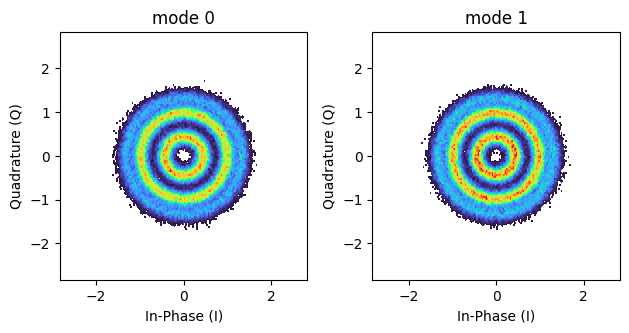

In [15]:
# Receiver

# parameters
chIndex  = 0    # index of the channel to be demodulated

freqGrid = paramTx.freqGrid
π  = np.pi
t  = np.arange(0, len(sigAWGN))*1/Fs 

print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (paramTx.Fc + freqGrid[chIndex])/1e12, const.c/(paramTx.Fc + freqGrid[chIndex])/1e-9))

symbTx = symbTx_[:,:,chIndex]

# local oscillator (LO) parameters:
FO      = 60e6                  # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated

# generate CW laser LO field
paramLO = parameters()
paramLO.P = 10              # power in dBm
paramLO.lw = 0*100e3        # laser linewidth
paramLO.RIN_var = 0
paramLO.Ns = len(sigAWGN)
paramLO.Fs = Fs

sigLO = basicLaserModel(paramLO)
sigLO = sigLO*np.exp(1j*2*π*Δf_lo*t) # add frequency offset

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(paramLO.P, paramLO.lw/1e3, FO/1e6))

# polarization multiplexed coherent optical receiver
sigRx = pdmCoherentReceiver(sigAWGN, sigLO, θsig = 0)

# plot constellation
pconst(sigRx[0::paramTx.SpS,:],R=2);

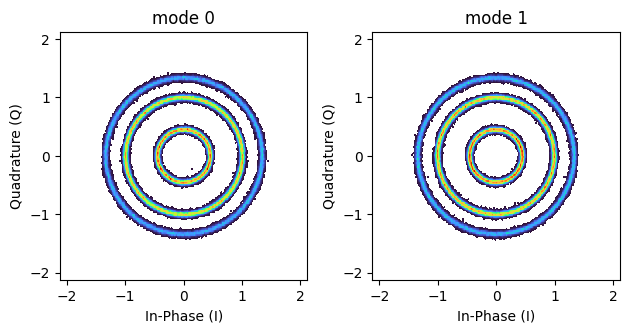

In [16]:
# Rx filtering

# Matched filtering
if paramTx.pulse == 'nrz':
    pulse = pulseShape('nrz', paramTx.SpS)
elif paramTx.pulse == 'rrc':
    pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)
    
pulse = pnorm(pulse)           
sigRx = firFilter(pulse, sigRx)

# decimation
paramDec = parameters()
paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 1
sigRx = decimate(sigRx, paramDec)

pconst(sigRx, R=1.5);

## Recuperação de frequência da portadora com o método de 4th potência

Compensa o deslocamento de frequência considerando um laser ideal sem ruído de fase.

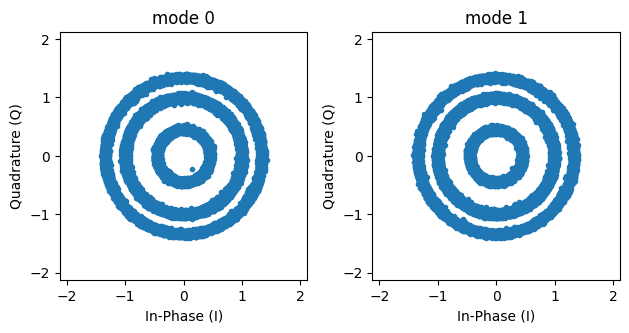

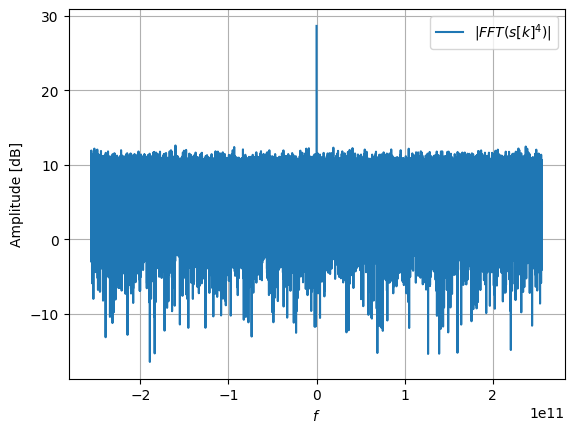

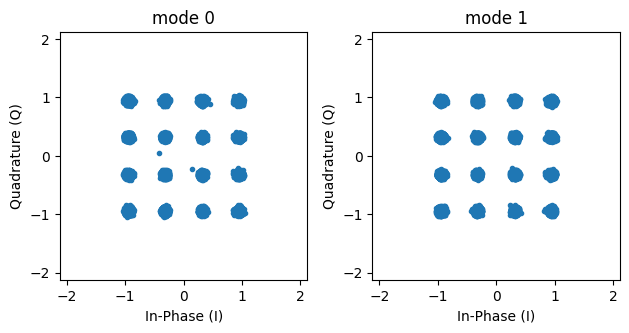

      pol.X      pol.Y      
 SER: 0.00e+00,  0.00e+00
 BER: 0.00e+00,  0.00e+00
 SNR: 29.46 dB,  29.43 dB


In [17]:
pconst(sigRx, R=1.5, pType='fast');
# compensa o deslocamento de frequência
sigRxFOE, indFO = fourthPower(sigRx, Fs, plotSpectrum=True)
pconst(sigRxFOE, R=1.5, pType='fast');

# Performance metrics
discard = 1000
d = pnorm(symbTx)

ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(sigRxFOE[ind,:], d[ind,:], paramTx.M, paramTx.constType)

print('      pol.X      pol.Y      ')
print(' SER: %.2e,  %.2e'%(SER[0], SER[1]))
print(' BER: %.2e,  %.2e'%(BER[0], BER[1]))
print(' SNR: %.2f dB,  %.2f dB'%(SNR[0], SNR[1]))